## Backgound
Analysis of the Chemotaxis model described by Spiro et al., PNAS, 1999.
The model describes the receptor state along 3 dimensions:
  - bound to a ligand
  - phosphorylated
  - degree of methylation (considers 2, 3, 4)
  
Key variables are:
   - Y, Yp - concentrations of CheY and its phosphorylated form
   - B, Bp - concentrations of CheB and its phosphorylated form
   - L - ligand concentration
   - f<state>, t<state> - "f" indicates the fraction of the concentration in the state, "t" is the total
     <state> is a 3 character string, such as "TT2". T/F indicates the boolean value; the last is an integer.
     
Below is a figure from Spiro describing the state structure of receptors.

Issues
 - yaxis labels are not showing
 - Overshoot steady state YP
 - Not getting correct time response for YP

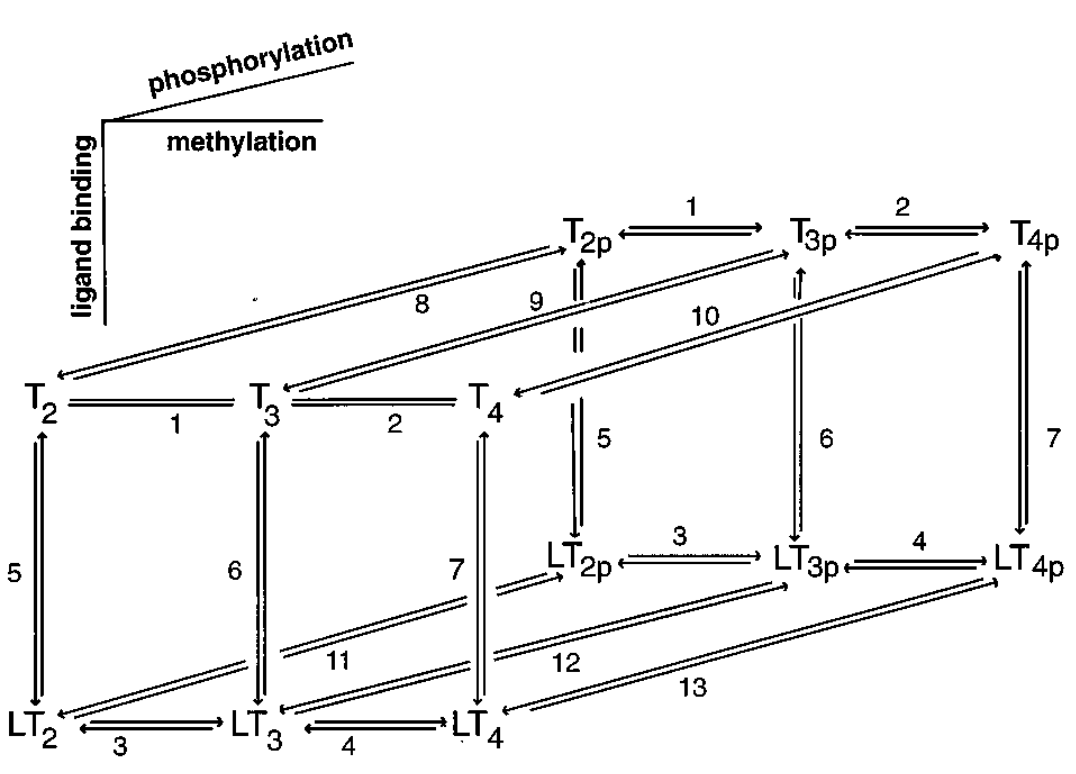

In [1]:
from IPython.display import Image, display
display(Image(filename='img/receptor_states.png'))

## Summary

Initially, we consider a step response. Later, we repeat the same analysis for a ramp. These correspond to the analyses done by Spiro.

Most of the analysis is done using fractional concentrations (variables that begin with "f"). We begin by justifying this.

Next, we analyze the effects of a step response. "Perfect adaptation" is possible if the step is small enough.

## Software Dependencies
The model and various utility functions are in the python modules chemotaxis_model and data_plotter.

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tellurium as te
from chemotaxis_model import ChemotaxisModel, StateAggregationFactory
from data_plotter import DataPlotter
model = ChemotaxisModel()

/home/ubuntu/miniconda2/lib/python2.7/site-packages/tellurium/notebooks/__init__.py:16: UserWarning: Notebook tools are not imported, due to missing dependencies.
  warnings.warn("Notebook tools are not imported, due to missing dependencies.")


## Antimony Model

In [63]:
print model.getModel()

# Template file for the Spiro model of chemotaxis in PNAS, 1999.
# The species B, R, T2, R, Y are specified separately.
#! SbStar Vesion 1.0 {'l': ['L', ''], 'm': ['2', '3', '4'], 'p': ['P', ''], 'r': ['R', '']} 
J0: $x0 -> L; k0*x0
# REACTIONS from Spiro, Table 3
# Methylation
J1_2{p}R: T2{p}R -> T3{p} + R; k1c*T2{p}R
J1_3{p}R: T3{p}R -> T4{p} + R; k2c*T3{p}R
J1_L2{p}R: LT2{p}R -> LT3{p} + R; k3c*LT2{p}R
J1_L3{p}R: LT3{p}R -> LT4{p} + R; k4c*LT3{p}R
# Demethylations
J4a_3{p}{r}: T3{p}{r} + Bp -> T2{p}{r} + Bp; k_1*T3{p}{r}*Bp
J4b_4{p}{r}: T4{p}{r} + Bp -> T3{p}{r} + Bp; k_2*T4{p}{r}*Bp
J4c_L3{p}{r}: LT3{p}{r} + Bp -> LT2{p}{r} + Bp; k_3*LT3{p}{r}*Bp
J4d_L4{p}{r}: LT4{p}{r} + Bp -> LT3{p}{r} + Bp; k_4*LT4{p}{r}*Bp
#   Details of *T* + R <-> *T*R
J2_{l}{m}{p}: {l}T{m}{p}R -> {l}T{m}{p} + R; k1a*{l}T{m}{p}R
J3_{l}{m}{p}: {l}T{m}{p} + R -> {l}T{m}{p}R; k1b*{l}T{m}{p}
# Ligand binding and unbinding
J5_{m}{p}{r}: L + T{m}{p}{r} -> LT{m}{p}{r}; k5*L*T{m}{p}{r}
J6_{m}{p}{r}: LT{m}{p}{r} -> L 

## Common Codes Used in this Analysis

In [83]:
# Runs simulation and creates global variables used in analysis
def sim(elements=None,end=400, concentrations={}):
    """
    Runs the simulation and creates global names
    :param list elements: additions to model
    :param int end: simulation end time
    :param dict concentrations: key is variable, value is assignment
    Output: global variables - plotter, result
    """
    if elements is None:
      elements = []
    global plotter, result, model
    model = ChemotaxisModel()
    for element in elements:
      model.appendToModel(element)
    rr = model.initialize()
    for k,v in concentrations.items():
      rr[k] = v
    result = model.run(end=end)
    plotter = DataPlotter(model)


## Justification for Fractional Concentrations

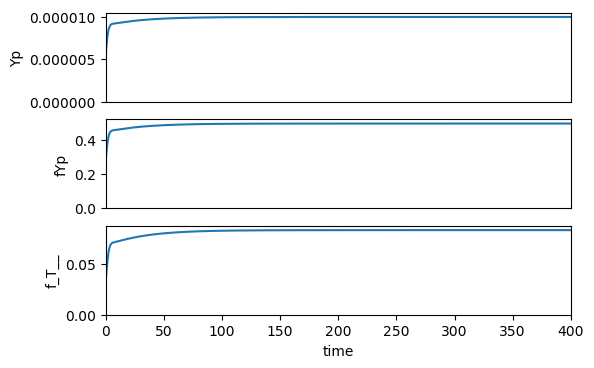

In [5]:
# Analysis for L = 0
sim()
plotter.lines(["Yp", "fYp", "f_T__"])

Observations
- Although the scales differ, the shape of Yp and fYp are identical.
- The Yp response corresponds to the shape of the fraction of methylated receptor

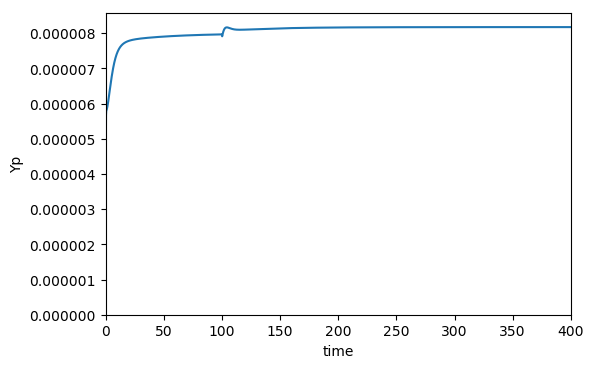

In [105]:
# Step Analysis for a change at 100
sim(elements=["at (time > 100): L = 0.11e-6"], concentrations={'R': 0.3e-6})
plotter.lines(["Yp"])

In [99]:
result['R']

array([  3.00000000e-07,   2.19454179e-07,   1.41398097e-07, ...,
        -2.59577574e-06,  -2.59577583e-06,  -2.59577593e-06])

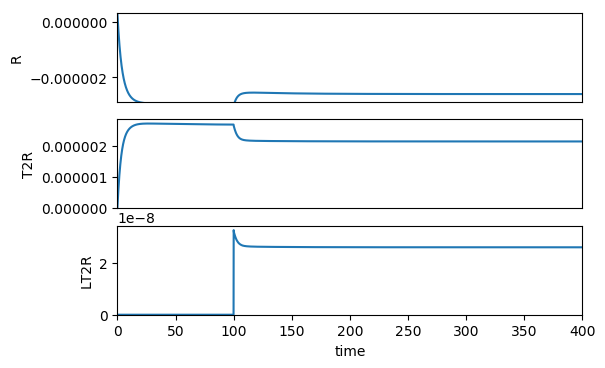

In [106]:
plotter.lines(["R", "T2R", "LT2R"])

Observations
- Why are there negative values of R

## Analysis of Step Response
The goal here is to understand the dynamics of the receptor state for a step response.
From the foregoing, we established that it's sufficient to look at the fraction of receptors that are in the phosphorylated state (since this correlates with Yp). Now we want to understand what substates contribute to phosphorylated receptors.

Spiro shows a step response plot with L going from 0 to 11uM and "perfect adaption of Yp. We do not see this. Possibly, this is because he used a model with more methylation levels. Below is Spiro's step response curve.

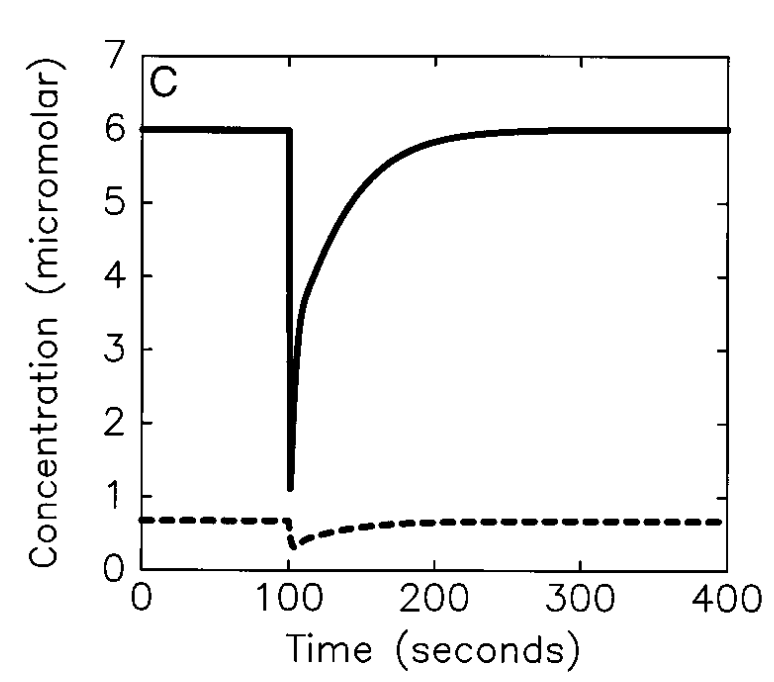

In [7]:
from IPython.display import Image, display
display(Image(filename='img/spiro_largestep.png'))

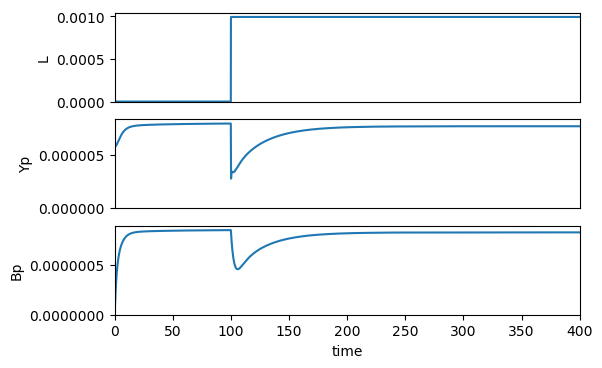

In [58]:
# What is the simulated step response for our model that corresponds to the Spiro?
# The solid line above is Yp and the dashed line is Bp; ligand concentration change is not shown.
sim(elements=["at (time > 100): L = 1e-3"])
plotter.lines(["L", "Yp", "Bp"])

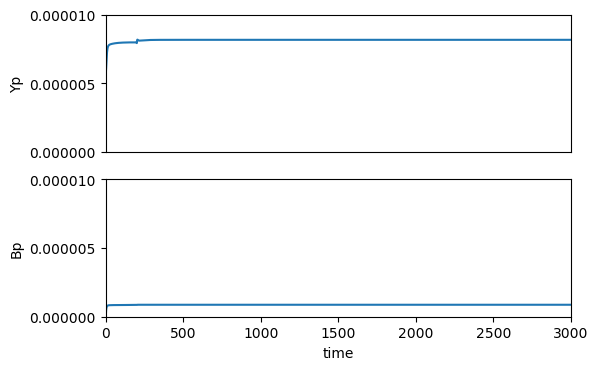

In [62]:
# What is the simulated step response for our model that corresponds to the Spiro?
# The solid line above is Yp and the dashed line is Bp; ligand concentration change is not shown.
sim(elements=["at (time > 200): L = 0.11e-6"], end=3000)
plotter.lines(["Yp", "Bp"], yrange=[0,10e-6])

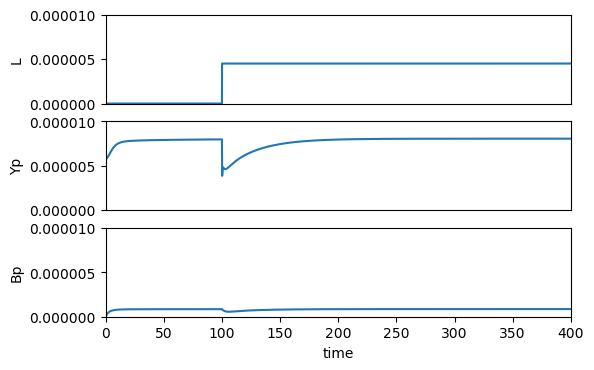

In [32]:
# Adjusting R gives a good response to a step
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["L", "Yp", "Bp"], yrange=[0,1e-5])

Observations
- Tuning the relationships between k1a and k1b (1.5e-9) allows for adaptation. 
- The time constant for the return to steady state is consistent with Spiro.
- The steady state value is 8uM, whereas in Spiro it's 6uM.

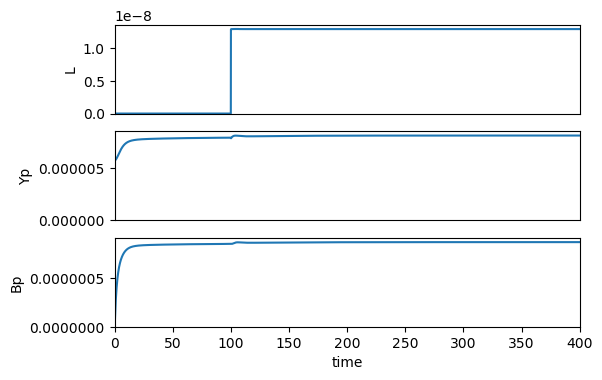

In [31]:
# Over adjusting R gives a substantial gain
sim(elements=["at (time > 100): L = 0.11e-6"])
plotter.lines(["L", "Yp", "Bp"])

Observations
- Alon et al., 1999 conduct experiments where R is changed 5-fold and there is no bias in the tumbling frequency after an adaptation time of 3 minutes.

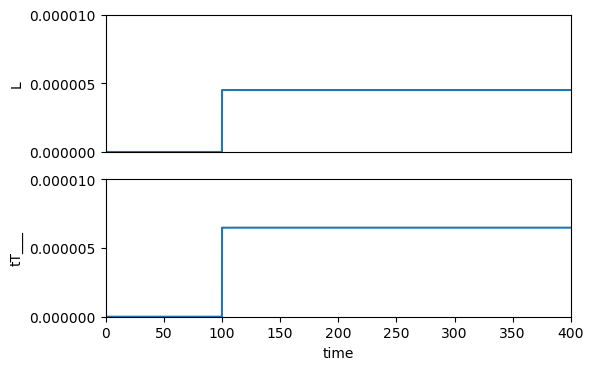

In [11]:
# Where does the ligand go?
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["L", "tT___"], yrange=[0, 10e-6])

Observations
- There are 8uM of receptors and we add 11uM of ligand. We end up with 6uM of bound receptors, and the rest is free Ligand. 
- k_on = k5 = 7e7; k_off = k_5 = 70. But since k_on is bimolecular, the reaction rate is much slower than the mono-molecular reverse reaction.

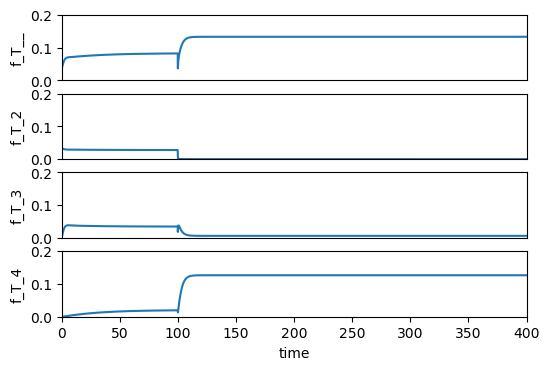

In [20]:
# Breakdown the state phosphorylation state by methylation level
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f_T__", "f_T_2", "f_T_3", "f_T_4"], yrange=[0,0.2])

Observations
 - Only 4% of the receptors get phosphorylated
 - LT4p plateaus, which might suggest that having more methylation levels would increase Yp
 
Questions
- How do I assess if have more methylation levels will provide adaptation without needing to adjust CheR?
- What is a more complete set of calibrations: Spiro (ramp, step), Alon (adaptation times)

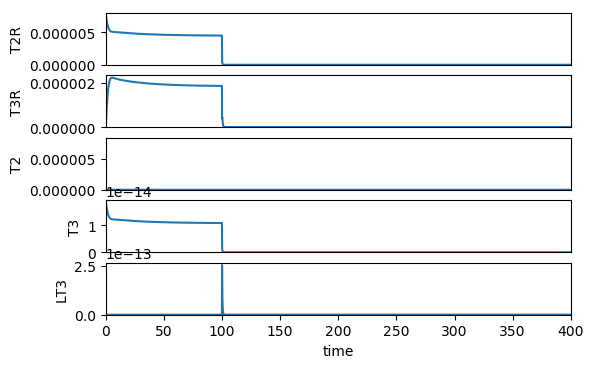

In [13]:
# Breakdown the state phosphorylation state by methylation level
sim(elements=["at (time > 100): L = 11e-6", "R = 0.3e-6"])
plotter.lines(["T2R", "T3R", "T2", "T3", "LT3"])

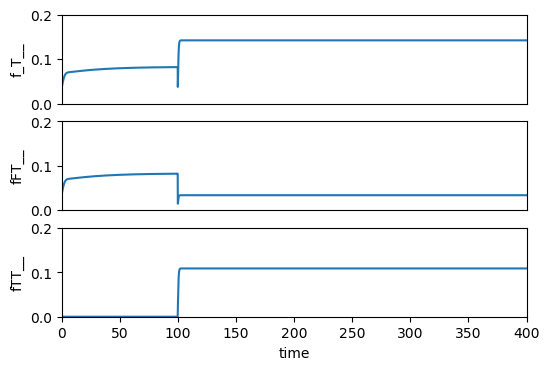

In [14]:
# Breakdown the state phosphorylations by ligand bound
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f_T__", "fFT__", "fTT__"], yrange=[0, 0.2])

Observations
- Most of the phosphorylation after the step is in receptors with the ligand bound

## Ramp analysis

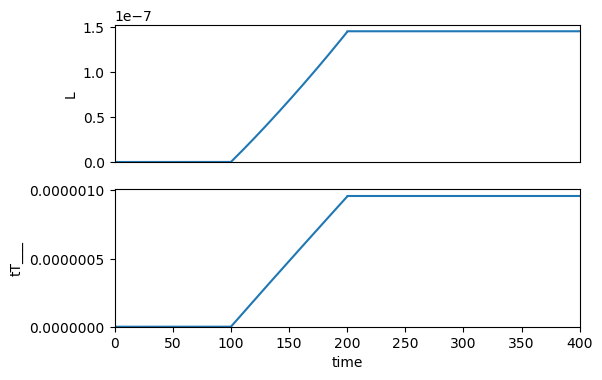

In [15]:
# Where does the ligand go?
elements = ["at (time > 100): k0 = 0.011e-6", "at (time > 200): k0 = 0, L=0.15e-6"]
sim(elements=elements)
plotter.lines(["L", "tT___"])

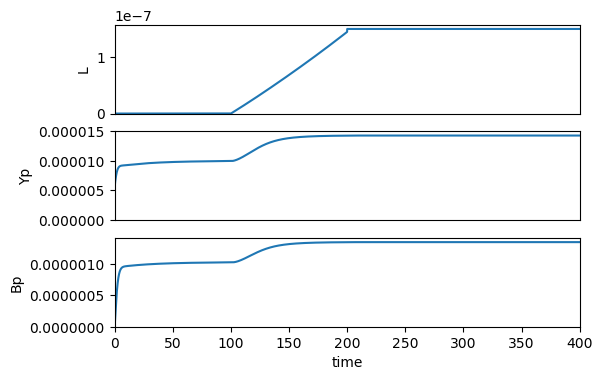

In [16]:
# Where does the ligand go?
elements = ["at (time > 100): k0 = 0.011e-6", "at (time > 200): k0 = 0, L=0.18e-6", "R = 2e-6"]
sim(elements=elements)
plotter.lines(["L", "Yp", "Bp"])

Observations
- The level of R is crucial in the adaptation rate.
- More R means that the system takes longer to respond initially (likely because of methylation without the presence of L)

Questions
- Would the presence of more methylation levels make the system less sensitive to R?

# Issues
 - I get a steady state of 8uM vs. 6uM in Spiro
 - Want to explore effect of changing concentrations of R and Z, as in Alon. Augment sim() to accept a dictionary of values.